In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import statistics
import math
import sys
from pylab import *
from math import log
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from generate_data import *
from train_models import *
from honest_trees import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Load spambase data
df = pd.read_csv('dataset/life-expectancy.csv')
X = df.drop('Age', axis=1).values
y = df['Age'].values

In [3]:
n_train = [100,250,500,750,1000,1500,2000,2500]
n_test = 500
d = len(X[0])
beta = 1
sigma = 0.1
sparsity = [8,10]
n_avg = 25

In [4]:
def log_list(t):
    return [math.log(x, math.e) if x != 0 else math.log(1e-10, math.e) for x in t]

In [5]:
def get_best_fit_line(x,y):
    m, b = np.polyfit(x, y, 1)
    return [m,b]

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# Xử lý dữ liệu phân loại bằng One-Hot Encoding
categorical_features = ['Gender', 'Physical_Activity', 'Smoking_Status', 'Alcohol_Consumption', 'Diet', 'Blood_Pressure']
numerical_features = ['Height', 'Weight', 'BMI', 'Cholesterol', 'Diabetes', 'Hypertension', 'Heart_Disease', 'Asthma']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough'
)

X_df = df.drop('Age', axis=1)
X_processed = preprocessor.fit_transform(X_df)

# ensure dense numpy array (OneHotEncoder may return sparse matrix)
if hasattr(X_processed, "toarray"):
    X_processed = X_processed.toarray()

# get correct processed feature names (sklearn >=1.0) or fallback for older versions
try:
    processed_feature_names = preprocessor.get_feature_names_out()
except Exception:
    ohe = preprocessor.named_transformers_['cat']
    cat_names = list(ohe.get_feature_names_out(categorical_features))
    processed_feature_names = cat_names + numerical_features

# create DataFrame with transformed column names
X_processed_df = pd.DataFrame(X_processed, columns=processed_feature_names)

# This cell uses Lasso to select important features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)
lasso = LassoCV(max_iter=10000, cv=5, random_state=0)
lasso.fit(X_scaled, y)

coefs = lasso.coef_

# map coefficients to processed feature names (not original feature_names)
important_features = [(name, coef) for name, coef in zip(processed_feature_names, coefs) if abs(coef) > 0]
print(f"Number of important features selected by Lasso: {len(important_features)}")

important_features_sorted = sorted(important_features, key=lambda x: abs(x[1]), reverse=True)

top_10_features = [name for name, _ in important_features_sorted[:10]]
print("Top 10 important features selected by Lasso:")
print(top_10_features)

Number of important features selected by Lasso: 19
Top 10 important features selected by Lasso:
['cat__Gender_Female', 'remainder__Heart_Disease', 'remainder__Hypertension', 'cat__Blood_Pressure_High', 'cat__Smoking_Status_Current', 'remainder__Diabetes', 'cat__Physical_Activity_High', 'cat__Diet_Poor', 'cat__Smoking_Status_Never', 'cat__Alcohol_Consumption_High']


In [7]:
# Initialize matrix for honest CART 
honest_CART_scores = []
honest_CART_error_bar = []
honest_CART_best_fit = []
#Initialize matrix for honest CART with CCP 
#honest_CART_CCP_scores = []
#honest_CART_CCP_error_bar = []

#Initialize matrix for dishonest CART 
CART_scores = []
CART_error_bar = []
CART_best_fit = []

#Initialize Matrix for dishonest CART with CCP 
#CART_CCP_scores = []
#CART_CCP_error_bar = []

#Initialize Matrix for RF
RF_scores = []
RF_error_bar = []
RF_best_fit = []
#Initialize matrix for theoretical lower bound 

In [8]:
#This cell's code is used to fit and predict for on linear model varying across the number of training samples/sparsity 
#shuffle data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

for s in sparsity: 
    honest_CART_s = []
    honest_CART_s_error_bar = []
    
    
    
    #honest_CART_CCP_s = []
    #honest_CART_CCP_s_error_bar = []
    CART_s = []
    CART_s_error_bar = []
  
    
    #CART_CCP_s = []
    #CART_CCP_s_error_bar = []
    
    RF_s = []
    RF_s_error_bar = []

    
    X_df = pd.DataFrame(X_processed, columns=processed_feature_names)  
    y_df = pd.Series(y)

    for n in tqdm(n_train):
        honest_CART = []
        #honest_CART_CCP = []
        CART = []
        #CART_CCP = []
        RF = []
        for j in range(n_avg):
            #Create data to fit models 
            top_s_features = top_10_features[:s]
            
            X_train = X_df.iloc[:n][top_s_features].reset_index(drop=True)
            y_train = y_df.iloc[:n].reset_index(drop=True)

            X_test = X_df.iloc[n:n+n_test][top_s_features].reset_index(drop=True)
            y_test = y_df.iloc[n:n+n_test].reset_index(drop=True)

            X_honest = X_df.iloc[-n:][top_s_features].reset_index(drop=True)
            y_honest = y_df.iloc[-n:].reset_index(drop=True)
            
            
            #Fit and predict for all versions of CART
            honest_CART_MSE,CART_MSE =  train_all_models(X_train,y_train,X_honest,y_honest,X_test,y_test,sigma,k = 5)
            honest_CART.append(honest_CART_MSE)
            
            
            
            #honest_CART_CCP.append(honest_CART_CCP_MSE)
            CART.append(CART_MSE)
            #CART_CCP.append(CART_CCP_MSE)
            
            #Fit and predict for RF
            rf = RandomForestRegressor(n_estimators = 100,max_features = 0.33)
            rf.fit(X_train,y_train)
            rf_preds = rf.predict(X_test)
            RF.append(mean_squared_error(y_test,rf_preds))
            
            
            
        #Store Performance in matrix
        honest_CART_s.append(statistics.mean(honest_CART))
        honest_CART_s_error_bar.append(statistics.stdev(honest_CART))
        
        #honest_CART_CCP_s.append(statistics.mean(honest_CART_CCP))
        #honest_CART_CCP_s_error_bar.append(statistics.stdev(honest_CART_CCP))
        
        CART_s.append(statistics.mean(CART))
        CART_s_error_bar.append(statistics.stdev(CART))
        
        #CART_CCP_s.append(statistics.mean(CART_CCP))
        #CART_CCP_s_error_bar.append(statistics.stdev(CART_CCP))
        
        RF_s.append(statistics.mean(RF))
        RF_s_error_bar.append(statistics.stdev(RF))
        

    
    #save results 
    honest_CART_scores.append(honest_CART_s)
    #honest_CART_CCP_scores.append(honest_CART_CCP_s)
    CART_scores.append(CART_s)
    #CART_CCP_scores.append(CART_CCP_s)
    RF_scores.append(RF_s)
    
    
    honest_CART_error_bar.append(honest_CART_s_error_bar)
    #honest_CART_CCP_error_bar.append(honest_CART_CCP_s_error_bar)
    CART_error_bar.append(CART_s_error_bar)
    #CART_CCP_error_bar.append(CART_CCP_s_error_bar) 
    RF_error_bar.append(RF_s_error_bar)

100%|██████████| 8/8 [04:42<00:00, 35.31s/it]


# Save Results 

In [9]:
honest_CART_results = (honest_CART_scores,honest_CART_error_bar)
with open('results/age/honestCART.pkl','wb') as f:
    pickle.dump(honest_CART_results, f)

In [10]:
CART_results = (CART_scores,CART_error_bar)
with open('results/age/CART.pkl','wb') as f:
    pickle.dump(CART_results,f)

In [11]:
RF_results = (RF_scores,RF_error_bar)
with open('results/age/RF.pkl','wb') as f:
    pickle.dump(RF_results,f)

# Best-fit line Slopes

In [12]:
for (i,s) in enumerate(sparsity):
    honest_CART_best_fit.append(get_best_fit_line(log_list(n_train),log_list(honest_CART_scores[i])))
    CART_best_fit.append(get_best_fit_line(log_list(n_train),log_list(CART_scores[i])))
    RF_best_fit.append(get_best_fit_line(log_list(n_train),log_list(RF_scores[i])))

# Plot Results 

In [13]:
import pylab
# Set global plotting parameters
plt.style.use("fivethirtyeight")
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
pylab.rcParams['xtick.major.pad'] = 5
pylab.rcParams['ytick.major.pad'] = 5
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['savefig.transparent'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'black'
# plt.rcParams['patch.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['grid.color'] = 'black'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

label_size = 25
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size


([<matplotlib.axis.YTick at 0x21065afd610>,
 [])

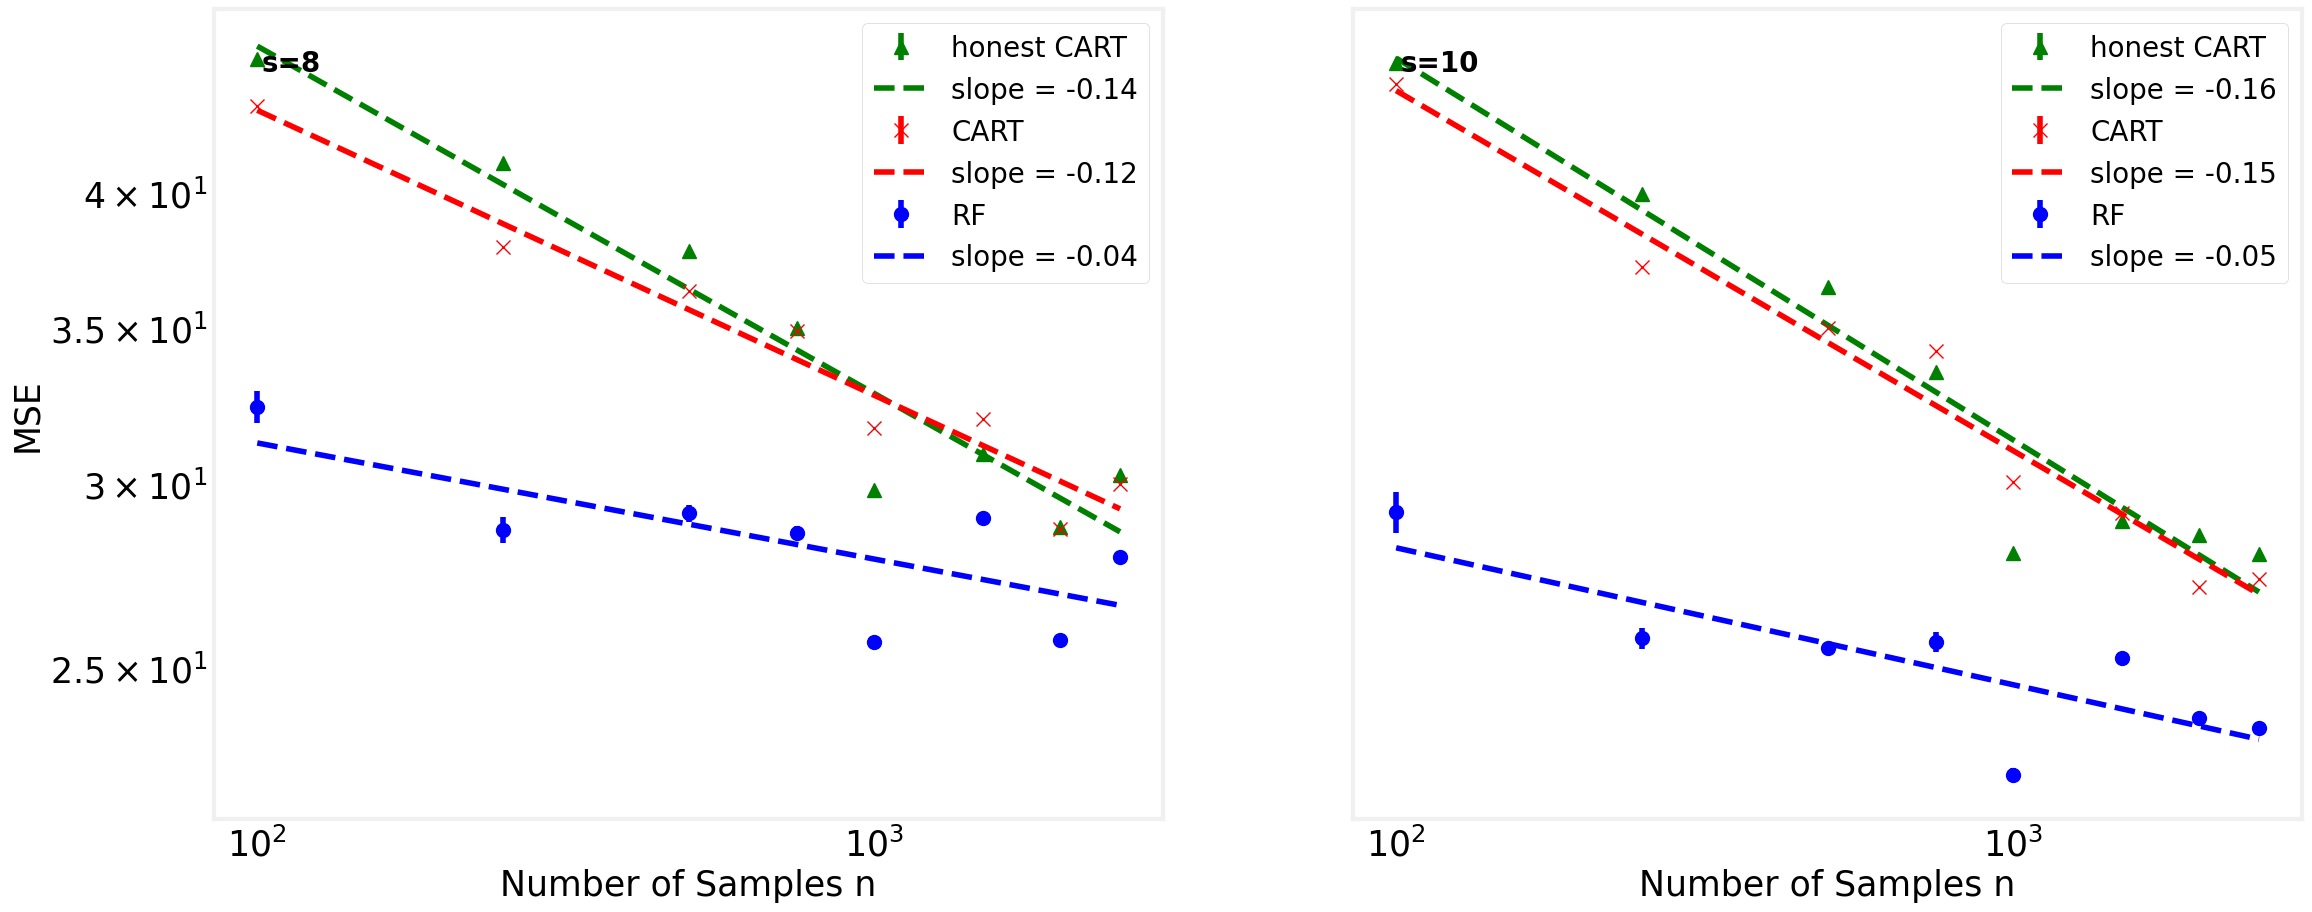

In [16]:
linear_lower_bound_fig,linear_lower_bound_axs = plt.subplots(1,2,figsize = (24,10),sharex = True,sharey = True)


#Plot Performance for different models 

# s = 8
linear_lower_bound_axs[0].errorbar(n_train,honest_CART_scores[0],yerr = honest_CART_error_bar[0],fmt = '^',label = 'honest CART',color = 'green')
linear_lower_bound_axs[0].errorbar(n_train,pow(math.e,honest_CART_best_fit[0][0]*np.array(log_list(n_train))+honest_CART_best_fit[0][1]),linestyle = 'dashed',label = 'slope = ' +str(honest_CART_best_fit[0][0])[:5],color = 'green')

linear_lower_bound_axs[0].errorbar(n_train,CART_scores[0],yerr = CART_error_bar[0],fmt = 'x',label = 'CART',color = 'red')
linear_lower_bound_axs[0].errorbar(n_train,pow(math.e,CART_best_fit[0][0]*np.array(log_list(n_train))+CART_best_fit[0][1]),linestyle = 'dashed',label = 'slope = ' + str(CART_best_fit[0][0])[:5],color = 'red')


linear_lower_bound_axs[0].errorbar(n_train,RF_scores[0],yerr = RF_error_bar[0],fmt = 'o',label = 'RF',color = 'blue')
linear_lower_bound_axs[0].errorbar(n_train,pow(math.e,RF_best_fit[0][0]*np.array(log_list(n_train))+RF_best_fit[0][1]),linestyle = 'dashed',label = 'slope = ' + str(RF_best_fit[0][0])[:5],color = 'blue')



# s = 10 
linear_lower_bound_axs[1].errorbar(n_train,honest_CART_scores[1],yerr = honest_CART_error_bar[0],fmt = '^',label = 'honest CART',color = 'green')
linear_lower_bound_axs[1].errorbar(n_train,pow(math.e,honest_CART_best_fit[1][0]*np.array(log_list(n_train))+honest_CART_best_fit[1][1]),linestyle = 'dashed',label = 'slope = ' +str(honest_CART_best_fit[1][0])[:5],color = 'green')

linear_lower_bound_axs[1].errorbar(n_train,CART_scores[1],yerr = CART_error_bar[1],fmt = 'x',label = 'CART',color = 'red')
linear_lower_bound_axs[1].errorbar(n_train,pow(math.e,CART_best_fit[1][0]*np.array(log_list(n_train))+CART_best_fit[1][1]),linestyle = 'dashed',label = 'slope = ' + str(CART_best_fit[1][0])[:5],color = 'red')


linear_lower_bound_axs[1].errorbar(n_train,RF_scores[1],yerr = RF_error_bar[1],fmt = 'o',label = 'RF',color = 'blue')
linear_lower_bound_axs[1].errorbar(n_train,pow(math.e,RF_best_fit[1][0]*np.array(log_list(n_train))+RF_best_fit[1][1]),linestyle = 'dashed',label = 'slope = ' +str(RF_best_fit[1][0])[:5],color = 'blue')








linear_lower_bound_axs[0].legend(loc = 'best')
linear_lower_bound_axs[1].legend(loc = 'best')

linear_lower_bound_axs[0].text(0.05, 0.95, 's=8',
      fontsize=20, fontweight='bold', va='top', ha='left', transform=linear_lower_bound_axs[0].transAxes)
linear_lower_bound_axs[1].text(0.05, 0.95, 's=10',
      fontsize=20, fontweight='bold', va='top', ha='left', transform=linear_lower_bound_axs[1].transAxes)
linear_lower_bound_axs[0].set_ylabel('MSE',fontsize = 25)
#linear_lower_bound_axs[1].set_ylabel('MSE',fontsize = 18)

linear_lower_bound_axs[0].set_xlabel('Number of Samples n',fontsize = 25)
linear_lower_bound_axs[1].set_xlabel('Number of Samples n',fontsize = 25)

linear_lower_bound_axs[0].set_yscale('log')
linear_lower_bound_axs[1].set_yscale('log')
linear_lower_bound_axs[0].set_xscale('log')
linear_lower_bound_axs[1].set_xscale('log')

linear_lower_bound_axs[0].grid()
linear_lower_bound_axs[1].grid()



#plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.5)

labels = [r'$2.5 \times 10^{1}$', r'$3 \times 10^{1}$', r'$3.5 \times 10^{1}$', r'$4 \times 10^{1}$']
ytick = [25,30,35,40]
#plt.xticks(n_train, labels, rotation='vertical')


#linear_lower_bound_axs[0].set_yticks([0.1, 0.5, 1.0,3.0])
plt.yticks(ytick,labels)
#linear_lower_bound_axs[0].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#linear_lower_bound_axs[0].set_ylim(0.1, 3.0);




In [17]:
linear_lower_bound_fig.savefig('figures/age_linear_lower_bound.png')